# Importing libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from math import sqrt
from time import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import class_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, balanced_accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import optimizers, backend, regularizers


#Reading and cleaning the data



As we import the data we will also replace the values ' ', '?' and '-' by a null/NaN value.

In [2]:
clients = pd.read_csv('customers.csv', sep = ';', na_values = [' ', '?', '-'])

In [3]:
clients.head(10)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,"29,85","29,85",No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,"56,95","1889,5",No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,"53,85","108,15",Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),"42,3","1840,75",No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,"70,7","151,65",Yes
5,9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,"99,65","820,5",Yes
6,1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),"89,1","1949,4",No
7,6713-OKOMC,Female,0,No,No,10,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,No,Mailed check,"29,75","301,9",No
8,7892-POOKP,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,"104,8","3046,05",Yes
9,6388-TABGU,Male,0,No,Yes,62,Yes,No,DSL,Yes,Yes,No,No,No,No,One year,No,Bank transfer (automatic),"56,15","3487,95",No


In [4]:
clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        7043 non-null   object
 1   gender            7043 non-null   object
 2   SeniorCitizen     7043 non-null   int64 
 3   Partner           7043 non-null   object
 4   Dependents        7043 non-null   object
 5   tenure            7043 non-null   int64 
 6   PhoneService      7043 non-null   object
 7   MultipleLines     7043 non-null   object
 8   InternetService   7043 non-null   object
 9   OnlineSecurity    7043 non-null   object
 10  OnlineBackup      7043 non-null   object
 11  DeviceProtection  7043 non-null   object
 12  TechSupport       7043 non-null   object
 13  StreamingTV       7043 non-null   object
 14  StreamingMovies   7043 non-null   object
 15  Contract          7043 non-null   object
 16  PaperlessBilling  7043 non-null   object
 17  PaymentMethod 

We can observe that the column "TotalCharges" has some null values, we could replace this values by the mean or the mode of the variable, but considering that the proportion of patients with null values is very low compared to the patients with complete information, dropping all data of this patients will be better for our model's efficience.

In [5]:
print(f'data shape before cleaning: {clients.shape}')
clean_data = clients.dropna()
print(f'data shape after cleaning NaNs: {clean_data.shape}')

data shape before cleaning: (7043, 21)
data shape after cleaning NaNs: (7032, 21)


We will also check for duplicate information when it comes to customerID.

In [6]:
clean_data.duplicated(subset=['customerID']).value_counts()

False    7032
dtype: int64

We will have to make changes in the original dataframe "clean_data" to alter variable types. To make this changes we will set pandas options to allow us to change slices of the data and we will check the data every time we make alterations.

In [7]:
pd.options.mode.chained_assignment = None #as we will change the original

"SeniorCitizen" is a qualitative evaluation of the customer, therefore we will transform this feature into a categorical. Later on we will treat this feature along with all the other categoricals, but for now this is better for analysis.

In [8]:
clean_data.loc[:,'SeniorCitizen'].replace({0: "No", 1: "Yes"}, inplace = True)
print(f'"SeniorCitizen" new type: {clean_data["SeniorCitizen"].dtype}\n')
clean_data.tail(5)

"SeniorCitizen" new type: object



,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
7038,6840-RESVB,Male,No,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,"84,8","1990,5",No
7039,2234-XADUH,Female,No,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),"103,2","7362,9",No
7040,4801-JZAZL,Female,No,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,"29,6","346,45",No
7041,8361-LTMKD,Male,Yes,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,"74,4","306,6",Yes
7042,3186-AJIEK,Male,No,No,No,66,Yes,No,Fiber optic,Yes,No,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),"105,65","6844,5",No


We could also observe when we read the data that the columns "MonthlyCharges" and "TotalCharges" were being interpreted as objects, to change their type to float we must first replace the ',' with an '.'

In [9]:
clean_data.loc[:,'MonthlyCharges'].replace({',':'.'}, regex= True, inplace = True)
clean_data.loc[:,'TotalCharges'].replace({',':'.'}, regex= True, inplace = True)
clean_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,No,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,No,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.3,1840.75,No
4,9237-HQITU,Female,No,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.7,151.65,Yes


In [10]:
clean_data = clean_data.astype({'MonthlyCharges': 'float32', 'TotalCharges':'float32'})
print(f'"MonthlyCharges" new type: {clean_data["MonthlyCharges"].dtype}')
print(f'"TotalCharges" new type: {clean_data["TotalCharges"].dtype}\n')
clean_data.head()

"MonthlyCharges" new type: float32
"TotalCharges" new type: float32



,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,No,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.850000,29.850000,No
1,5575-GNVDE,Male,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.950001,1889.500000,No
2,3668-QPYBK,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.849998,108.150002,Yes
3,7795-CFOCW,Male,No,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.299999,1840.750000,No
4,9237-HQITU,Female,No,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.699997,151.649994,Yes


We will set the customerID as index of the dataframe.

In [11]:
clean_data.set_index('customerID', inplace = True)
clean_data.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Female,No,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.850000,29.850000,No
5575-GNVDE,Male,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.950001,1889.500000,No
3668-QPYBK,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.849998,108.150002,Yes
7795-CFOCW,Male,No,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.299999,1840.750000,No
9237-HQITU,Female,No,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.699997,151.649994,Yes


Lastly we will remove the outliers (customers that do not follow the common behaviour) inside each of the classes of Churn. Only execute this once, because multiple executions of outliers will keep removing customers because the mean and quantiles change once they are removed.

In [12]:
labels = clean_data["Churn"].unique()
class_data_v = [clean_data.query('Churn == "{}"'.format(label)) for label in labels]
new_data = pd.DataFrame()

print('Outlier customers: ')
for class_data in class_data_v:
    Q1 = class_data.quantile(0.25)
    Q3 = class_data.quantile(0.75)
    IQR = Q3 - Q1
    
    is_outlier = ((class_data < (Q1 - 1.5 * IQR)) | (class_data > (Q3 + 1.5 * IQR))).any(axis=1)
    
    print(list(class_data.index[is_outlier]))
    class_data = class_data.drop(class_data.index[is_outlier], axis=0)
    new_data = pd.concat([new_data,class_data])
clean_data = new_data
print(f'Clean data new shape: {clean_data.shape}')

Outlier customers: 
[]
['3192-NQECA', '1343-EHPYB', '0979-PHULV', '7752-XUSCI', '3419-SNJJD', '7207-RMRDB', '4913-EHYUI', '3009-JWMPU', '2239-JALAW', '4853-RULSV', '2382-BCKQJ', '7549-MYGPK', '2834-JRTUA', '6646-QVXLR', '6818-WOBHJ', '2408-TZMJL', '0201-OAMXR', '4791-QRGMF', '3838-OZURD', '9518-RWHZL', '5469-CTCWN', '2886-KEFUM', '9651-GTSAQ', '2003-CKLOR', '3092-IGHWF', '6097-EQISJ', '6990-YNRIO', '9614-RMGHA', '0348-SDKOL', '3424-NMNBO', '7694-VLBWQ', '6481-OGDOO', '2659-VXMWZ', '3571-RFHAR', '1587-FKLZB', '5440-FLBQG', '3870-MQAMG', '5236-PERKL', '0407-BDJKB', '4446-BZKHU', '3351-NQLDI', '3763-GCZHZ', '0310-MVLET', '4550-VBOFE', '0596-BQCEQ', '1891-FZYSA', '7317-GGVPB', '8809-RIHDD', '8849-GYOKR', '1625-JAIIY', '0917-EZOLA', '0748-RDGGM', '1150-WFARN', '6771-XWBDM', '1725-IQNIY', '2533-QVMSK', '5089-IFSDP', '3886-CERTZ', '0946-CLJTI', '0324-BRPCJ', '2748-MYRVK', '6559-ILWKJ', '4088-YLDSU', '2632-UCGVD', '5445-PZWGX', '6425-YQLLO', '5502-RLUYV', '8580-QVLOC', '2889-FPWRM', '6305-YLBM

#Exploring the data



Firstly we will check the distribution of the data's categorical features.

In [13]:
for feature in clean_data.columns:
  if clean_data[feature].dtype == object:
    print(clean_data[feature].value_counts())
    print()

Male      3485
Female    3434
Name: gender, dtype: int64

No     5805
Yes    1114
Name: SeniorCitizen, dtype: int64

No     3605
Yes    3314
Name: Partner, dtype: int64

No     4845
Yes    2074
Name: Dependents, dtype: int64

Yes    6242
No      677
Name: PhoneService, dtype: int64

No                  3375
Yes                 2867
No phone service     677
Name: MultipleLines, dtype: int64

Fiber optic    2988
DSL            2411
No             1520
Name: InternetService, dtype: int64

No                     3427
Yes                    1972
No internet service    1520
Name: OnlineSecurity, dtype: int64

No                     3055
Yes                    2344
No internet service    1520
Name: OnlineBackup, dtype: int64

No                     3066
Yes                    2333
No internet service    1520
Name: DeviceProtection, dtype: int64

No                     3407
Yes                    1992
No internet service    1520
Name: TechSupport, dtype: int64

No                     2800
Yes 

We can see that some features are balanced, like "gender" which has a almost 50/50 distribution between the classes, but other feature are not balanced at all. 

In this case partitularly, we will focus on voluntary churn of the clients, so we must be aware that the classes are unbalanced (the amount of clients that remained in the base are almost 3x the amount of clients that left the base) and this will be very important when we do model evaluation.

Secondly we check the statistics, distribution and Kernel density estimation (KDE) of the data's numerical features.

In [14]:
clean_data.describe()

,tenure,MonthlyCharges,TotalCharges
count,6919.000000,6919.000000,6919.000000
mean,31.904032,64.184906,2213.273438
std,24.395289,29.906481,2214.690186
min,1.000000,18.250000,18.799999
25%,9.000000,35.049999,388.250000
50%,28.000000,70.099998,1363.250000
75%,54.000000,89.400002,3626.825073
max,72.000000,118.750000,8672.450195


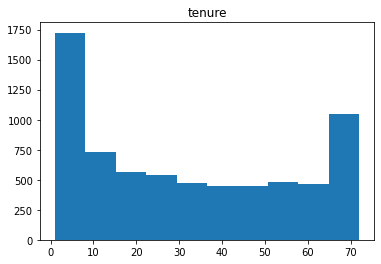

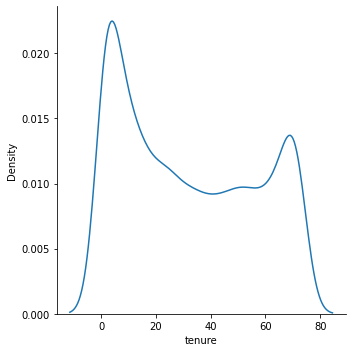

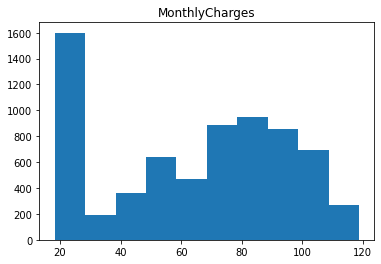

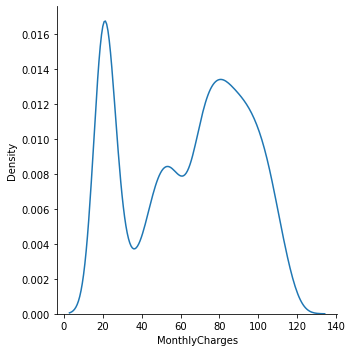

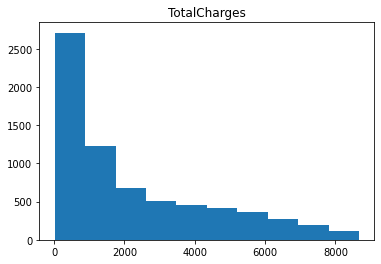

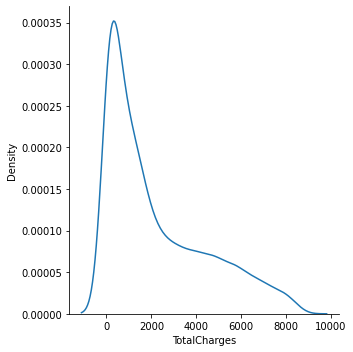

In [15]:
for feature in clean_data.columns:
  if clean_data[feature].dtype != object:
    plt.hist(clean_data[feature])
    plt.title(feature)
    sns.displot(clean_data, x=feature, kind="kde")
    plt.show()
    print()
    

## Distribution for customer tenure

first, let's focus on the histogram and KDE.

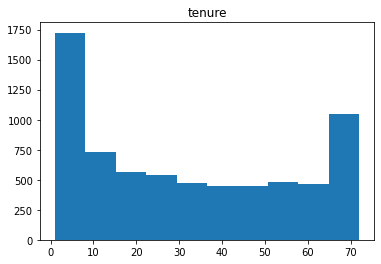

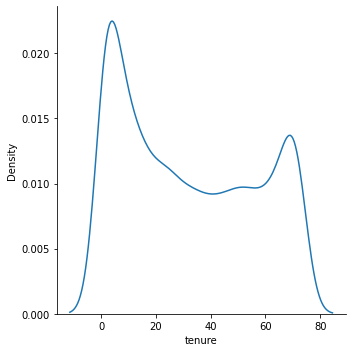

In [16]:
plt.hist(clean_data['tenure'])
plt.title('tenure')
plt.show()
sns.displot(clean_data, x='tenure', kind="kde")

The feature has two peaks, one close to very low values and the other close to very large values. This plots suggest a bimodal distribution, in other words, two different modes representing two different groups inside the feature. 

In this case, many of the customers can be grouped with "low tenure" and others with "high tenure". We could binarize this feature using the valley as a threshold (around tenure = 40), but considering there is still a reasonable density around this area, we will just make further analysis also taking into consideration the feature "churn".

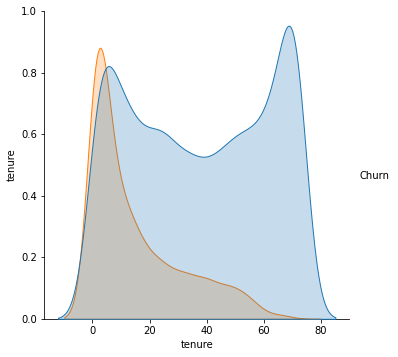

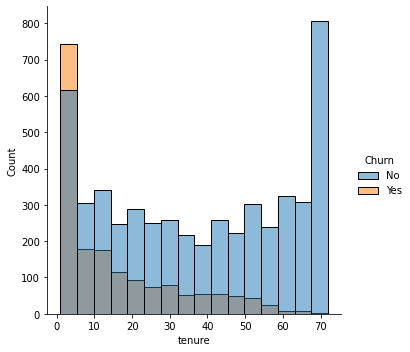

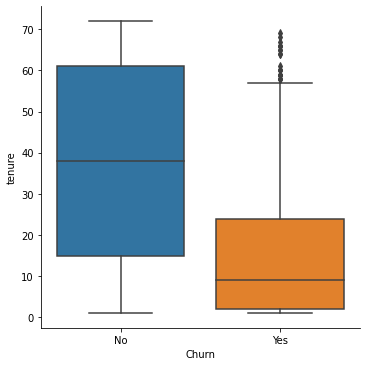

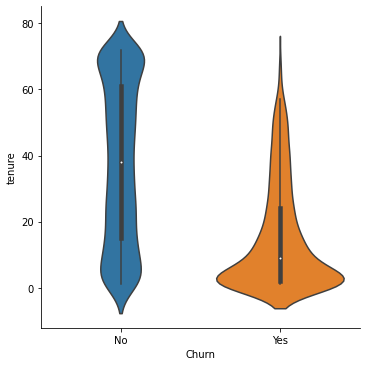

In [17]:
sns.pairplot(clean_data, x_vars='tenure', y_vars='tenure', hue = 'Churn', height = 5)
sns.displot(clean_data, x='tenure', hue = 'Churn')
sns.catplot(x="Churn", y="tenure", kind="box", data=clean_data)
sns.catplot(x="Churn", y="tenure", kind="violin", data=clean_data)

In the plots above we can tell that the distribution of "tenure" is very different depending on the occurence of voluntary churn. The distribution of the customers that remained in the base is balanced and simmetric between the interval, but the majority of customers that left the base had low tenure. This lead us to conclude that the more time the customer stays in the base, less likely is for them to eventually leave.

# Selecting the features

To select the features we must analyse which ones that are the most relevant to differenciate between the two classes of "churn". 

In order to do this we will first create two auxiliary dataframes: one with all the customers who left the base (Churn = "Yes") and other with the customers that remained (Churn = "No").

In [18]:
churn_y, churn_n = [x for _, x in clean_data.groupby(clean_data['Churn'] == 'No')] 

In [19]:
churn_n.head(3)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Female,No,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.850000,29.85,No
5575-GNVDE,Male,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.950001,1889.50,No
7795-CFOCW,Male,No,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.299999,1840.75,No


In [20]:
churn_y.head(3)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,,,,,,,,,,,,,,
3668-QPYBK,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.849998,108.150002,Yes
9237-HQITU,Female,No,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.699997,151.649994,Yes
9305-CDSKC,Female,No,No,No,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.650002,820.500000,Yes


## Analysing the numeric features



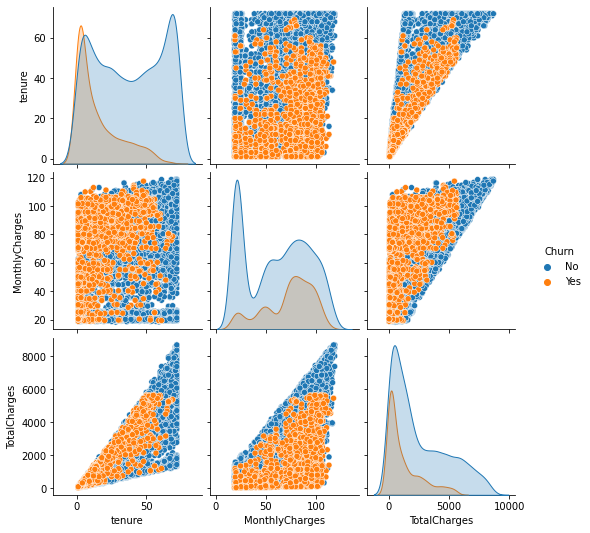

In [21]:
sns.pairplot(clean_data, hue="Churn")
plt.show()

Looking only at the numeric features we can see that Tenure and Monthlycharges are the most revelant. This makes sense because as we discussed before, the more the customer stays in the base the more it is likely for them to remain. 

Besides, most of the customers that have a low monthly charge remain in the base and most of the customers that left the base had a high monthly charge, this indicates that the customers are price sensitive in some sense.

The difference in total charges is mostly because the less time the customer stays in the base, the lower the total charges. Besides, total charges is almost a combination between tenure and monthly charges.

## Analysing the categorical features

Let's visualize the proportion of the features' classes for each churn class


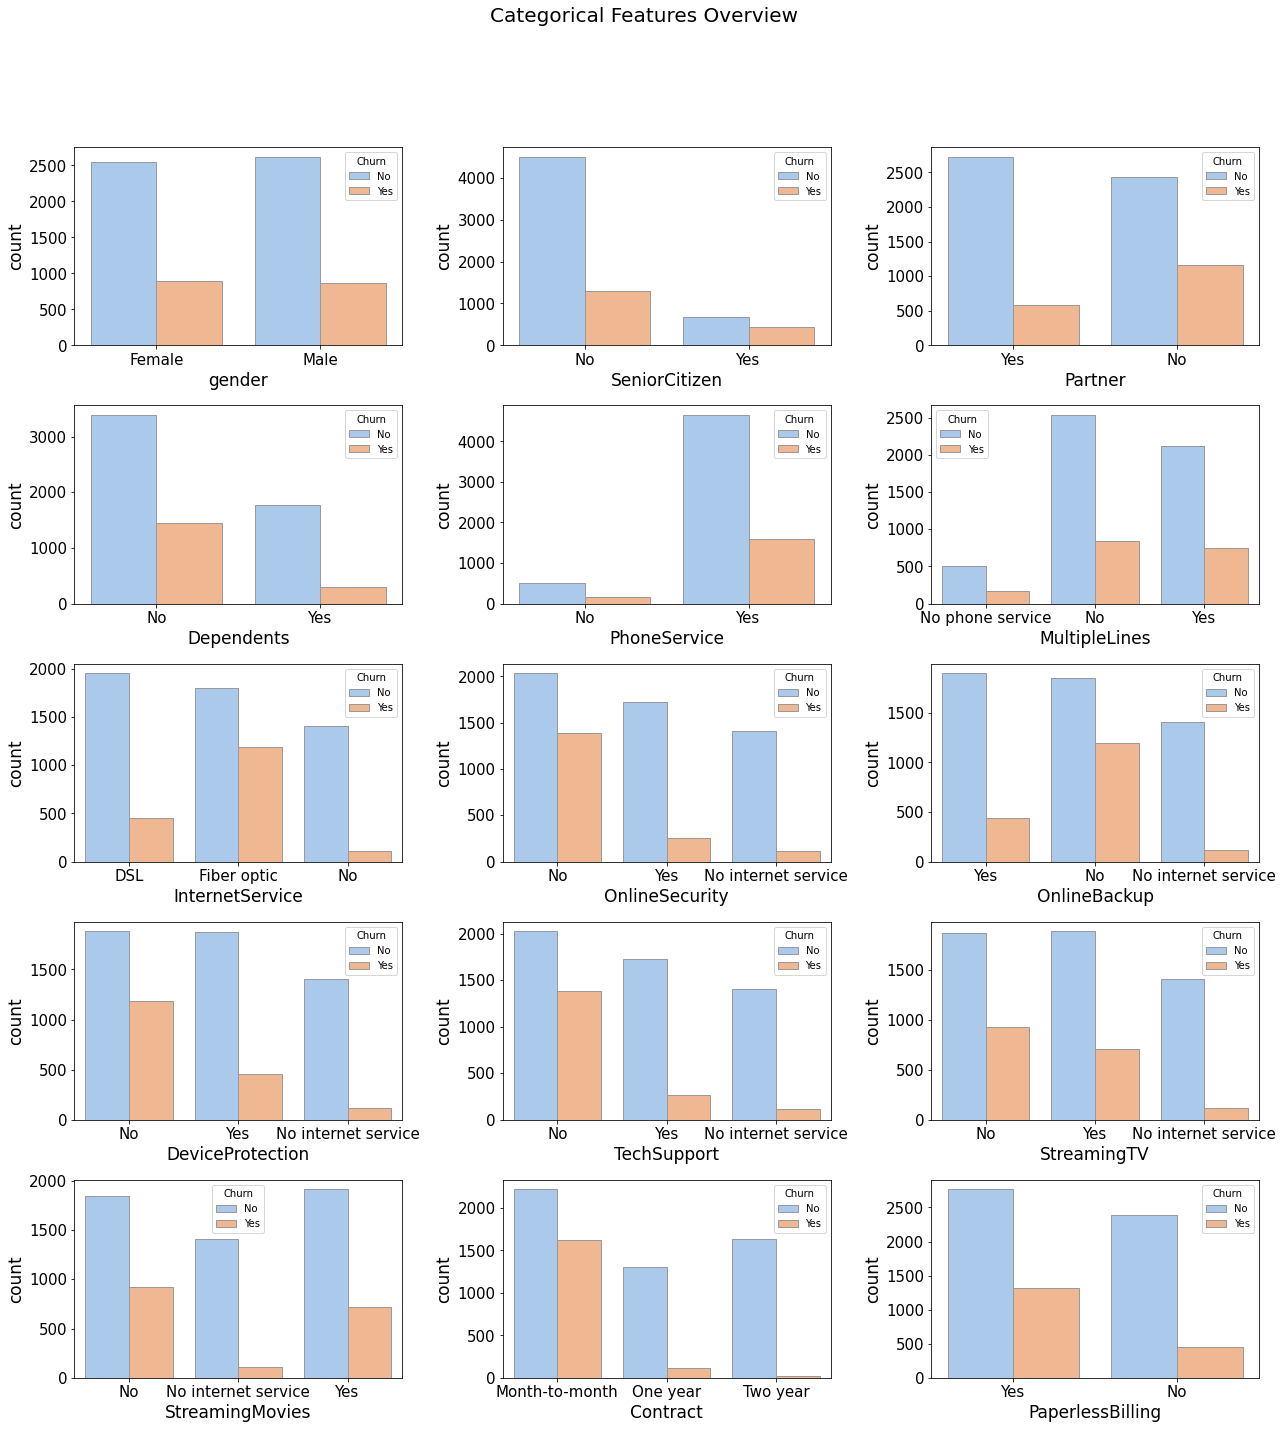

In [22]:
fig, ax = plt.subplots(5,3, figsize=(18,18))
list_features = []
for coluna in clean_data.columns[:-1]:
  if clean_data[coluna].dtype == object:
    list_features.append(coluna)

n=0
for j in range(len(ax)):
    for i in range(len(ax[j])):
        ax[j][i].tick_params(labelsize=15)
        ax[j][i].set_xlabel(list_features[n], fontsize=17, position=(.5,20))
        ax[j][i].set_ylabel('Quantidade', fontsize=17)
        ax[j][i] = sns.countplot(x=list_features[n], hue="Churn", palette="pastel", edgecolor=".6", data=clean_data, ax = ax[j][i])
        n+=1
fig.suptitle('Categorical Features Overview', position=(.5,1.1), fontsize=20)
fig.tight_layout()

fig.show()

Just by looking at the data we can tell that gender is not a good feature to predict churn, because the proportion between who leaves the base and who doesn't is almost identical in both male and female. 

On the other hand, SeniorCitizen seems to be very relevant, because while between those who are senior citizens the churn classes are very similar, the ones that are not senior citizens are almost 3x more likely to remain customers than to leave the base.

In some cases it may be better to visualize using numbers. 

In [23]:
for coluna in clean_data.columns[:-1]:
  if clean_data[coluna].dtype == object:
    print('Left the base:')
    print(churn_y[coluna].value_counts())
    print()
    print('Remained in the base:')
    print(churn_n[coluna].value_counts())
    print('-------------------------------------')

Left the base:
Female    890
Male      866
Name: gender, dtype: int64

Remained in the base:
Male      2619
Female    2544
Name: gender, dtype: int64
-------------------------------------
Left the base:
No     1308
Yes     448
Name: SeniorCitizen, dtype: int64

Remained in the base:
No     4497
Yes     666
Name: SeniorCitizen, dtype: int64
-------------------------------------
Left the base:
No     1166
Yes     590
Name: Partner, dtype: int64

Remained in the base:
Yes    2724
No     2439
Name: Partner, dtype: int64
-------------------------------------
Left the base:
No     1455
Yes     301
Name: Dependents, dtype: int64

Remained in the base:
No     3390
Yes    1773
Name: Dependents, dtype: int64
-------------------------------------
Left the base:
Yes    1589
No      167
Name: PhoneService, dtype: int64

Remained in the base:
Yes    4653
No      510
Name: PhoneService, dtype: int64
-------------------------------------
Left the base:
No                  839
Yes                 750
N

We could decide bases only on the observation done so far, but it would be hard to distinguish between the variables which ones are the best to predict churn, since many appear to be very similar, like StreamingTV and StreamingMovies. 

With categorical data we can't calculate correlation, so we have two options: find a way to calculate the most relevant features using them as categorical, or transforming them into numerical features and then calculating correlation between the features and churn. 

Both methods were done and will be explained, but the second method is the most efficient first because we can compare both numerical and categorical variables, and second because allow us to focus on the best classes of the best features and avoid losing time training with data that is not so meaningfull. On the other hand, it is a solution that we don't choose a feature, but a "slice" of a feature and therefore we could lose in accuracy (which in the future tests will prove to be an irrelevant lost).



### Option 1: choosing features as categorical

The first option to choose the best features would be to divide the customers in the two churn classes, calculate the proportion of the classes in each feature inside these two groups, and them compare the groups, perhabs using RMSE (root-mean-square-deviation). This means that the features with highest RMSE are the ones with the biggest difference between the churn classes and therefore, the best to predict churn.

In [24]:
### function that receives the value_count of a feature and returns the porcentage of each class in that feature ###
def porcentage(count_data):
  porc = []
  for classes in count_data.index:
    value = count_data[classes]
    porcent = value/(count_data.sum())
    porc.append(porcent)
  return porc

Just as a test, observe that the porcentage of the customers that didn't have StreamingTV is much higher (50.4%) between the customers that left the base than between the customers that remained in the base (36.6%). 

This indicates that having StreamingTV is a factor for customers to stay with the service.

In [25]:
print('StreamingTV')
print(churn_n['StreamingTV'].unique())
print()
print(f'No churn:')
print(porcentage(churn_n['StreamingTV'].value_counts()))
print(f'Churn:')
print(porcentage(churn_y['StreamingTV'].value_counts()))  

StreamingTV
['No' 'Yes' 'No internet service']

No churn:
[0.36587255471625024, 0.36161146620182066, 0.2725159790819291]
Churn:
[0.5313211845102506, 0.4043280182232346, 0.06435079726651481]


We can calculate the RMSE between the porcentagens for churn and no churn for each of the variables.

In [26]:
errors = {}

for coluna in clean_data.columns[:-1]:
  if clean_data[coluna].dtype == object:
    pn = porcentage(churn_n[coluna].value_counts())
    py = porcentage(churn_y[coluna].value_counts())
    error = round(sqrt(mean_squared_error(pn, py)),4)
    errors[coluna] = error
    print(coluna)
    print()
    print(f'No churn: {pn}')
    print(f'churn: {py}') 
    print(f'RMSE: {error}')
    print('-------------------------------------')

gender

No churn: [0.5072632190586868, 0.4927367809413132]
churn: [0.5068337129840547, 0.49316628701594534]
RMSE: 0.0004
-------------------------------------
SeniorCitizen

No churn: [0.8710052295177223, 0.12899477048227775]
churn: [0.744874715261959, 0.255125284738041]
RMSE: 0.1261
-------------------------------------
Partner

No churn: [0.5276002324230099, 0.47239976757699015]
churn: [0.664009111617312, 0.3359908883826879]
RMSE: 0.1364
-------------------------------------
Dependents

No churn: [0.6565950029052876, 0.3434049970947124]
churn: [0.8285876993166287, 0.1714123006833713]
RMSE: 0.172
-------------------------------------
PhoneService

No churn: [0.9012202208018594, 0.09877977919814061]
churn: [0.9048974943052391, 0.09510250569476082]
RMSE: 0.0037
-------------------------------------
MultipleLines

No churn: [0.4911872942087933, 0.41003292659306606, 0.09877977919814061]
churn: [0.4777904328018223, 0.4271070615034169, 0.09510250569476082]
RMSE: 0.0127
---------------------

No we can rank and choose the features with highest errors, because this ones will have the biggest impact to predict churn.

In [27]:
errors_rank = pd.DataFrame.from_dict(errors, orient='index')
errors_rank.sort_values(by = 0, ascending=False)

,0
Contract,0.3495
OnlineSecurity,0.2814
TechSupport,0.2788
OnlineBackup,0.2269
DeviceProtection,0.2228
InternetService,0.2162
PaperlessBilling,0.2105
PaymentMethod,0.1910
Dependents,0.1720
StreamingTV,0.1555


Since we decided to use the numerical features "tenure" and "MonthlyCharges", we will pick the 3 highest errors, which correspond to "Contract", "OnlineSecurity" and "TechSupport".

#### Features: tenure, MonthlyCharges, Contract, OnlineSecurity and TechSupport.

### Option 2: transforming categorical to numerical data

We will transform the categorical to numerical data by using one-hot encoding,which is basically creating additional columns for each class inside the variable and setting one if the customer belongs to that class. 

This is the best way to transform this data, because if we chose to turn each class of a variable into a number (1 for class1, 2 for class2, etc...) the model would interpret a class2 as being 2x bigger than class1 since 2 is 2x bigger than 1, and this makes no sense when it comes to classes.

In [28]:
hot_enc_data = pd.get_dummies(clean_data)
hot_enc_data.head()

,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,SeniorCitizen_No,SeniorCitizen_Yes,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_No,Churn_Yes
customerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,1,29.850000,29.850000,1,0,1,0,0,1,1,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0
5575-GNVDE,34,56.950001,1889.500000,0,1,1,0,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1,1,0
7795-CFOCW,45,42.299999,1840.750000,0,1,1,0,1,0,1,0,1,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,1,0,1,0,0,0,1,0
1452-KIOVK,22,89.099998,1949.400024,0,1,1,0,1,0,0,1,0,1,0,0,1,0,1,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,1,0
6713-OKOMC,10,29.750000,301.899994,1,0,1,0,1,0,1,0,1,0,0,1,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0


Now we calculate the correlation between each column and the column "Churn_Yes", which corresponds to the customers that left the base, and rank the features with highest correlation (both positive and negative are valid). 

In [29]:
df = {}
for coluna in hot_enc_data.columns.drop(['Churn_Yes','Churn_No']):
  correla = pd.Series(hot_enc_data['Churn_Yes']).corr(pd.Series(hot_enc_data[coluna]))
  df[coluna] = correla

df_corr = pd.DataFrame.from_dict(df, orient='index')
df_corr.rename(columns = {0:'Correlation to churn'}, inplace = True)
df_corr = df_corr.apply(np.abs, axis=1)
df_corr.sort_values(by = 'Correlation to churn', ascending=False)

,Correlation to churn
Contract_Month-to-month,0.432868
tenure,0.403904
OnlineSecurity_No,0.346243
TechSupport_No,0.342996
Contract_Two year,0.311699
PaymentMethod_Electronic check,0.303623
InternetService_Fiber optic,0.288753
OnlineBackup_No,0.284687
DeviceProtection_No,0.270681
TotalCharges,0.264865


In this option we will be able to focus on specific classes inside each feature, instead of using all the information about that feature. For example, having Fiber optic as internet service may be very relevant to predict churn of that customer, but having DSL may not be as relevant, so using the whole feature "InternetService" as an input is feeding the model with both relevant and irrelevant data. 

In this sense it's smartter to fit the model with the specific classes that have shown to be more relevant instead of the whole features. Therefore we will choose the 5 best classes as the inputs of the model.

#### Features: Contract_Month-to-month, tenure, OnlineSecurity_No, TechSupport_No and InternetService_Fiber optic.

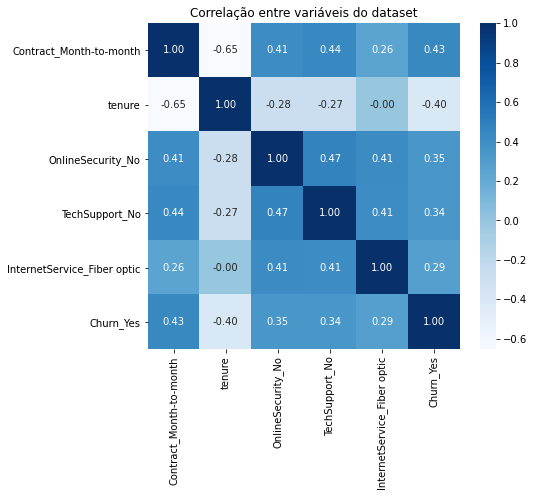

In [30]:
inputs = hot_enc_data[['Contract_Month-to-month', 'tenure', 'OnlineSecurity_No', 'TechSupport_No', 'InternetService_Fiber optic','Churn_Yes']]

plt.figure(figsize=(7, 6))
sns.heatmap(inputs.corr(),
            annot = True,
            fmt = '.2f',
            cmap='Blues')
plt.title('Correlação entre variáveis do dataset')
plt.show()

# Choosing the model

Our goal is to be able to predict if the customer is likely to leave the base so that the company can properly respond and avoid the customer's churn with retention models.

This task is a binary classification problem using supervised learning, because we are trying to predict if the customer will voluntary churn or not based on his data and the previous customers who had already been labeled with yes/no churn.

We have a total of 6919 customers, to be split between test and train, and 5 features.

It is necessary to select a model that is able to classificate the customer as part of one of the

Some possible options would be:
- a KNN (K-nearest neighbors), that classifies the customers without label (test) based on his the similarity with the labeled customers (train).
- a Random forest, that runs several different decision trees that classify the customer analysing each feature in a certain order, and pick the mode between their classification.
- an ANN (Artificial neural network), that trains considering different weights for each feature and adjust the weights to increase the accuracy for the training until it reaches a stopping point, and then classifies the test with the same weights.

We will train all this 3 models and observe their metrics.

## Splitting the data in train and test.

We will use the same split for all 3 models to guarantee same base for comparison. Consider 80% for training and 20% for testing.

In [31]:
x_train1,x_test1,y_train1,y_test1, indtrain, indtest = train_test_split(inputs.drop(['Churn_Yes'], axis = 'columns'), inputs['Churn_Yes'], inputs.index, train_size = 0.8, random_state = 20)


print(f'inputs training shape: {x_train1.shape}')
print(f'inputs testing shape: {x_test1.shape}')
print(f'outputs training shape: {y_train1.shape}')
print(f'outputs testing shape: {y_test1.shape}')

inputs training shape: (5535, 5)
inputs testing shape: (1384, 5)
outputs training shape: (5535,)
outputs testing shape: (1384,)


In [32]:
x_train1.head()

,Contract_Month-to-month,tenure,OnlineSecurity_No,TechSupport_No,InternetService_Fiber optic
customerID,,,,,
8063-GBATB,1,27,1,1,1
4456-RHSNB,1,19,1,1,0
6905-NIQIN,1,1,1,1,0
9560-BBZXK,0,36,0,1,0
7931-PXHFC,0,38,1,0,0


We will create a dataframe to store the predictions of the customers from "test", so we can save as csv later.

In [33]:
predictions = pd.DataFrame(index = indtest)
for column in clean_data.columns:
  predictions[column] = clean_data.loc[:,column]

print(predictions.shape)
predictions.head()

(1384, 20)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,,,,,,,,,,,,,,
4760-XOHVN,Female,No,Yes,Yes,1,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,19.450001,19.450001,Yes
0363-QJVFX,Male,No,No,No,32,Yes,Yes,Fiber optic,Yes,Yes,No,Yes,Yes,Yes,Month-to-month,Yes,Credit card (automatic),108.150002,3432.899902,Yes
8329-GWVPJ,Female,No,Yes,Yes,50,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),69.750000,3557.699951,No
4547-LYTDD,Female,No,No,No,16,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,No,Electronic check,72.650002,1194.300049,Yes
3665-JATSN,Female,No,No,No,19,No,No phone service,DSL,No,Yes,No,No,No,Yes,Month-to-month,Yes,Electronic check,39.700001,710.049988,No


We will also normalize the data, because each feature has a different range, and therefore without normalization the features with highest values will influence more than the features with lowest values, despite the actual correlation to the prediction.

In this case that we have categorical features turned into numeric, it is best a normalize than standardize ir order not to change the 1 and 0 of the features.

In [34]:
scaler = MinMaxScaler() 
indexes = list(x_train1.columns)
x_train1 = pd.DataFrame(scaler.fit_transform(x_train1), columns = indexes)
x_test1 = pd.DataFrame(scaler.fit_transform(x_test1), columns = indexes)


In [35]:
x_train1.head()

,Contract_Month-to-month,tenure,OnlineSecurity_No,TechSupport_No,InternetService_Fiber optic
0,1.0,0.366197,1.0,1.0,1.0
1,1.0,0.253521,1.0,1.0,0.0
2,1.0,0.000000,1.0,1.0,0.0
3,0.0,0.492958,0.0,1.0,0.0
4,0.0,0.521127,1.0,0.0,0.0


Considering that the classes are unbalanced, we also need to measure the weight of the classes, otherwise the model will give more relevance to the more represented class.

In [36]:
weight_classes1 = class_weight.compute_class_weight(class_weight = 'balanced', classes = np.unique(y_train1), y = np.ravel(y_train1))

## Random Forest

To choose the number of estimators the model was trained multiple times with different values and the choosen one was the lowest value where from that point forward an increase in value had an insignificant increase in accuracy.

In [37]:
start_time = time()
forest = RandomForestClassifier(n_estimators = 10, class_weight = {0: weight_classes1[0], 1: weight_classes1[1]}, random_state = 20)
print(forest.fit(x_train1,y_train1))
stop_time = time()
total_time = stop_time - start_time

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 0.6678330115830116,
                                     1: 1.9895758447160317},
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=20, verbose=0,
                       warm_start=False)


In [38]:
print(f'Total training time (in seconds): {total_time}')

Total training time (in seconds): 0.0473783016204834


We can also check the metrics of this model.

In [39]:
accur1 = forest.score(x_test1,y_test1)
print(f'Acuracia do teste: {accur1}')

Acuracia do teste: 0.7702312138728323


In [40]:
y_pred1 = forest.predict(x_test1)
randforest_classif = classification_report(y_test1, y_pred1)
print(randforest_classif)

print(f'balanced accuracy: {balanced_accuracy_score(y_test1, y_pred1)}')

              precision    recall  f1-score   support

           0       0.92      0.76      0.83      1019
           1       0.54      0.81      0.65       365

    accuracy                           0.77      1384
   macro avg       0.73      0.78      0.74      1384
weighted avg       0.82      0.77      0.78      1384

balanced accuracy: 0.7824216596986033


Saving the predictions in the dataframe.

In [41]:
predictions['Random_forest_predictions'] = pd.Series(y_pred1, index = y_test1.index).replace({0: "No", 1: "Yes"})
print(predictions.shape)
predictions.head()

(1384, 21)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Random_forest_predictions
customerID,,,,,,,,,,,,,,,,,,,,,
4760-XOHVN,Female,No,Yes,Yes,1,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,19.450001,19.450001,Yes,Yes
0363-QJVFX,Male,No,No,No,32,Yes,Yes,Fiber optic,Yes,Yes,No,Yes,Yes,Yes,Month-to-month,Yes,Credit card (automatic),108.150002,3432.899902,Yes,No
8329-GWVPJ,Female,No,Yes,Yes,50,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),69.750000,3557.699951,No,Yes
4547-LYTDD,Female,No,No,No,16,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,No,Electronic check,72.650002,1194.300049,Yes,Yes
3665-JATSN,Female,No,No,No,19,No,No phone service,DSL,No,Yes,No,No,No,Yes,Month-to-month,Yes,Electronic check,39.700001,710.049988,No,No


As we can see the model has a reasonable balanced accuracy (78.24%), very good precision classifying customers that remain, a bad precision classifying customers' churn and reasonable recall in both cases. This means that in general the model is good, but when it predicts the no churn of the customer it is right almost every time (92%) and when it predicts the churn it is right only half of the time (54%), similar to if he was guessing. 

We can visualize this even better when checking the true/false positives and negatives. Out of 840 predictions of not churn, it was right 770 times, while when it predicted churn, it was right only 300 out of 550.

Total tests: 1384


Text(24.0, 0.5, 'Truth')

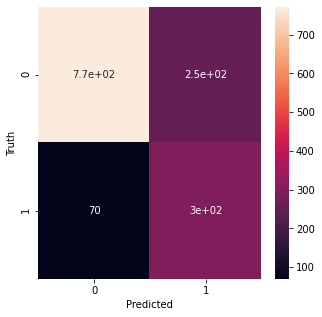

In [42]:
cm1 = confusion_matrix(y_test1, y_pred1)
print(f'Total tests: {len(y_test1)}')
import seaborn as sn
import matplotlib.pyplot as plt
plt.figure(figsize = (5,5))
sn.heatmap(cm1, annot = True)
plt.xlabel('Predicted')
plt.ylabel('Truth')


We can also check the rank of relevant each feature had when predicting the churn in this model.

In [43]:
feat_list1 = list(x_train1.columns)
pd.Series(forest.feature_importances_, index = feat_list1).sort_values(ascending = False)

tenure                         0.509997
Contract_Month-to-month        0.271125
InternetService_Fiber optic    0.079094
TechSupport_No                 0.070883
OnlineSecurity_No              0.068901
dtype: float64

## Random forest with whole features - extra test

To check the use of whole features instead of a slice of the feature, as we have one previously, will affect or not the model we will run a test. We have to turn the categorical data into numerical data, same as before, but using the whole features this will lead to 13 columns instead of 5 like the previous model.

In [44]:
ent2 = pd.get_dummies(clean_data[['Contract', 'tenure', 'OnlineSecurity', 'TechSupport', 'InternetService']])
lab2 = pd.get_dummies(clean_data['Churn'], drop_first=True)

x_train2,x_test2,y_train2,y_test2 = train_test_split(ent2, lab2, train_size = 0.8, random_state = 20)
weight_classes2 = class_weight.compute_class_weight(class_weight = 'balanced', classes = np.unique(y_train2), y = np.ravel(y_train2))

print(f'inputs training shape: {x_train2.shape}')
print(f'inputs testing shape: {x_test2.shape}')
print(f'outputs training shape: {y_train2.shape}')
print(f'outputs testing shape: {y_test2.shape}')

#notice that shape of labels are (****, 1) instead of (****,) like the situation before, to avoid this we must use ravel when we refer to the labels.

inputs training shape: (5535, 13)
inputs testing shape: (1384, 13)
outputs training shape: (5535, 1)
outputs testing shape: (1384, 1)


Observe that, since in both splits we used random_state = 20, both splits will be exactly the same indexes (customers) and will only change the columns (features).

In [45]:
x_train2.head()

,tenure,Contract_Month-to-month,Contract_One year,Contract_Two year,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No
customerID,,,,,,,,,,,,,
8063-GBATB,27,1,0,0,1,0,0,1,0,0,0,1,0
4456-RHSNB,19,1,0,0,1,0,0,1,0,0,1,0,0
6905-NIQIN,1,1,0,0,1,0,0,1,0,0,1,0,0
9560-BBZXK,36,0,0,1,0,0,1,1,0,0,1,0,0
7931-PXHFC,38,0,1,0,1,0,0,0,0,1,1,0,0


In [46]:
scaler = MinMaxScaler() 
indexes2 = list(x_train2.columns)
x_train2 = pd.DataFrame(scaler.fit_transform(x_train2), columns = indexes2)
x_test2 = pd.DataFrame(scaler.transform(x_test2), columns = indexes2)

In [47]:
start_time = time()
forest2 = RandomForestClassifier(n_estimators = 10, class_weight = {0: weight_classes2[0], 1: weight_classes2[1]} , random_state = 20)
print(forest2.fit(x_train2, np.ravel(y_train2)))
stop_time = time()
total_time = stop_time - start_time

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 0.6678330115830116,
                                     1: 1.9895758447160317},
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=20, verbose=0,
                       warm_start=False)


In [48]:
print(f'Total training time (in seconds): {total_time}')

Total training time (in seconds): 0.04900717735290527


In [49]:
accur2 = forest2.score(x_test2,np.ravel(y_test2))
print(f'Acuracia do teste: {accur2}')

Acuracia do teste: 0.7658959537572254


In [50]:
y_pred2 = forest2.predict(x_test2)
print(classification_report(y_test2, y_pred2))
print(f'balanced accuracy: {balanced_accuracy_score(y_test2, y_pred2)}')


              precision    recall  f1-score   support

           0       0.92      0.75      0.83      1019
           1       0.54      0.81      0.65       365

    accuracy                           0.77      1384
   macro avg       0.73      0.78      0.74      1384
weighted avg       0.82      0.77      0.78      1384

balanced accuracy: 0.7803567827711831


1384


Text(24.0, 0.5, 'Truth')

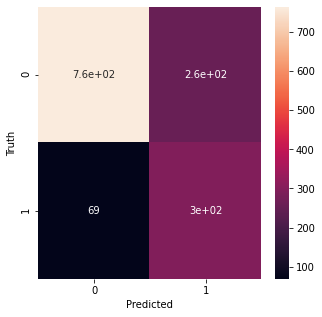

In [51]:
cm2 = confusion_matrix(y_test2, y_pred2)
print(len(y_test2))
import seaborn as sn
import matplotlib.pyplot as plt
plt.figure(figsize = (5,5))
sn.heatmap(cm2, annot = True)
plt.xlabel('Predicted')
plt.ylabel('Truth')


Notice that using the same model, same training and same testing, this option takes more time (even if slightly) to have lower accuracy, precision and recall. Therefore, as said before, it is more efficient to use the best classes as input instead of the best variables.

In [52]:
feat_list2 = list(x_train2.columns)
pd.Series(forest2.feature_importances_, index = feat_list2).sort_values(ascending = False)

tenure                                0.502540
Contract_Month-to-month               0.217646
TechSupport_No                        0.083021
Contract_Two year                     0.075987
InternetService_Fiber optic           0.027747
OnlineSecurity_No                     0.025690
Contract_One year                     0.023535
InternetService_DSL                   0.016999
TechSupport_Yes                       0.009643
OnlineSecurity_Yes                    0.008620
TechSupport_No internet service       0.005494
OnlineSecurity_No internet service    0.002562
InternetService_No                    0.000516
dtype: float64

## KNN

To choose the number of neighbors the model was trained multiple times with different values and the choosen one was the lowest value where from that point forward an increase in value had an insignificant increase in accuracy.

In [53]:
start_time = time()
k_class = KNeighborsClassifier(n_neighbors= 30)
print(k_class.fit(x_train1, y_train1))
stop_time = time()
total_time = stop_time - start_time

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=30, p=2,
                     weights='uniform')


In [54]:
print(f'Total training time (in seconds): {total_time}')

Total training time (in seconds): 0.02160811424255371


In [55]:
y_pred3 = k_class.predict(x_test1)
knn_classif = classification_report(y_test1, y_pred3)
print(knn_classif)

print(f'balanced accuracy: {balanced_accuracy_score(y_test1, y_pred3)}')

              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1019
           1       0.64      0.51      0.57       365

    accuracy                           0.79      1384
   macro avg       0.74      0.70      0.72      1384
weighted avg       0.78      0.79      0.79      1384

balanced accuracy: 0.7036619301759717


1384


Text(24.0, 0.5, 'Truth')

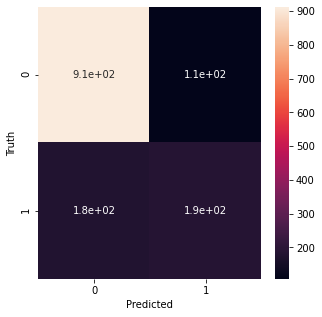

In [56]:
cm3 = confusion_matrix(y_test1, y_pred3)
print(len(y_test1))
import seaborn as sn
import matplotlib.pyplot as plt
plt.figure(figsize = (5,5))
sn.heatmap(cm3, annot = True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

Saving the predictions in the dataframe.

In [57]:
predictions['KNN_predictions'] = pd.Series(y_pred3, index = y_test1.index).replace({0: "No", 1: "Yes"})
print(predictions.shape)
predictions.head()

(1384, 22)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Random_forest_predictions,KNN_predictions
customerID,,,,,,,,,,,,,,,,,,,,,,
4760-XOHVN,Female,No,Yes,Yes,1,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,19.450001,19.450001,Yes,Yes,No
0363-QJVFX,Male,No,No,No,32,Yes,Yes,Fiber optic,Yes,Yes,No,Yes,Yes,Yes,Month-to-month,Yes,Credit card (automatic),108.150002,3432.899902,Yes,No,No
8329-GWVPJ,Female,No,Yes,Yes,50,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),69.750000,3557.699951,No,Yes,Yes
4547-LYTDD,Female,No,No,No,16,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,No,Electronic check,72.650002,1194.300049,Yes,Yes,Yes
3665-JATSN,Female,No,No,No,19,No,No phone service,DSL,No,Yes,No,No,No,Yes,Month-to-month,Yes,Electronic check,39.700001,710.049988,No,No,No


Using KNN resulted in a consistently good precision and recall predicting no churn customers (84% and 89%) and consistently average results predicting churn (64% and 51%), besides an slightly lower balanced accuracy (70.36%). On the other hand it has faster, tooking less than half of the time random forest took to train. 

## ANN 

For this model each variable (number of layers, number of neurons in each layer, drop rate,  regularization value and epochs) had two or three values tested. Below is one of the two options that generated the best results, it used only 1 layer of 64 neurons, 20% drop rate, $10^{-4}$ regularization and 100 epochs.

A similar model with same drop, regularization and epochs, but 2 layers with 32 neurons each, had very similar results, but using around 3 times more params,therefore the simplest model was preferable.

It is important to point out that every time your run this model it will give different metric values, and considering that we can't save/load a model with its weights and bias in this challenge, the comparison will be done based on the values at the time this notebook is being written and may be different for the reader as he/she runs the model again.

In [58]:
def model(n_neurons1, n_neurons2 = 32, drop = 0.2, regul = 0.0001):
  backend.clear_session()
  tf.keras.backend.set_floatx('float64')

  classificador = Sequential() 
  classificador.add(Dense(units = n_neurons1, activation = 'relu', kernel_regularizer=regularizers.l2(regul))) 
  classificador.add(Dropout(drop))

  #classificador.add(Dense(units = n_neurons2, activation = 'relu', kernel_regularizer=regularizers.l2(regul)))
  #classificador.add(Dropout(drop))

  classificador.add(Dense(units = 1, activation = 'sigmoid')) 

  opt = optimizers.Adam(learning_rate=0.0001)
  classificador.compile(loss = 'binary_crossentropy', optimizer = opt,
                      metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.TruePositives(), tf.keras.metrics.TrueNegatives(), tf.keras.metrics.FalsePositives(), tf.keras.metrics.FalseNegatives()],
                      weighted_metrics=['accuracy']
                      )  
  return classificador

We will use test data as validation data but only to plot the evolution of accuracy and loss during the epochs for both training and validation(test data). It will not interfer in the performance of the model.

Epoch 1/100
173/173 [==============================] - 1s 6ms/step - loss: 0.6544 - accuracy: 0.7107 - precision: 0.4487 - recall: 0.6600 - true_positives: 918.0000 - true_negatives: 3016.0000 - false_positives: 1128.0000 - false_negatives: 473.0000 - weighted_accuracy: 0.6939 - val_loss: 0.6494 - val_accuracy: 0.7421 - val_precision: 0.5065 - val_recall: 0.8493 - val_true_positives: 310.0000 - val_true_negatives: 717.0000 - val_false_positives: 302.0000 - val_false_negatives: 55.0000 - val_weighted_accuracy: 0.7421
Epoch 2/100
173/173 [==============================] - 0s 2ms/step - loss: 0.6310 - accuracy: 0.7221 - precision: 0.4679 - recall: 0.7714 - true_positives: 1073.0000 - true_negatives: 2924.0000 - false_positives: 1220.0000 - false_negatives: 318.0000 - weighted_accuracy: 0.7385 - val_loss: 0.6395 - val_accuracy: 0.7334 - val_precision: 0.4969 - val_recall: 0.8767 - val_true_positives: 320.0000 - val_true_negatives: 695.0000 - val_false_positives: 324.0000 - val_false_negati

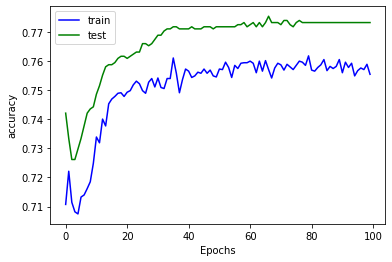

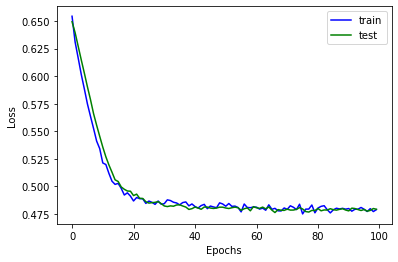

In [59]:
n_neurons = 32
drop = 0.2
regularization = 0.0001

start_time = time()
acc_balanceada = []

ann = model(n_neurons, drop = drop, regul = regularization)
epocas = 100

history = ann.fit(x_train1, y_train1,
                  batch_size = 32, epochs = epocas, class_weight = {0: weight_classes1[0], 1: weight_classes1[1]}, 
                  validation_data = (x_test1, y_test1))

plt.plot(history.history['accuracy'], 'b')
plt.plot(history.history['val_accuracy'], 'g')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'], 'b')
plt.plot(history.history['val_loss'], 'g')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

end_time = time()
total_time = end_time - start_time

In [60]:
print(f'Total training time (in seconds): {total_time}')

Total training time (in seconds): 39.02244758605957


In [61]:
metrics = ann.evaluate(x_test1, y_test1)

44/44 [==============================] - 0s 2ms/step - loss: 0.4792 - accuracy: 0.7731 - precision: 0.5455 - recall: 0.8384 - true_positives: 306.0000 - true_negatives: 764.0000 - false_positives: 255.0000 - false_negatives: 59.0000 - weighted_accuracy: 0.7731


Since the result of the ANN is a probability from 0 to 1 that the classification is True (label = 1), we chose a label based on the probability.

In [62]:
y_pred4 = ann.predict(x_test1)
y_pred4 = pd.Series(np.ravel(y_pred4), index = y_test1.index)
y_pred4 = y_pred4.apply(lambda x : 0 if x < 0.5 else 1)

ann_classif = classification_report(y_test1, y_pred4)
print(ann_classif)

print(f'balanced accuracy: {balanced_accuracy_score(y_test1, y_pred4)}')

              precision    recall  f1-score   support

           0       0.93      0.75      0.83      1019
           1       0.55      0.84      0.66       365

    accuracy                           0.77      1384
   macro avg       0.74      0.79      0.75      1384
weighted avg       0.83      0.77      0.79      1384

balanced accuracy: 0.7940554129081694


Observe that the compared to random forest all the metrics were very similar, but it's relevant to point out that both balanced accuracy of this model and recall in the class 1 (churn customers) is higher then in the other models shown before. On the other hand the training took much more time for this model (46.4 seconds compared to less than 0.1 second on the others).

1384


Text(24.0, 0.5, 'Truth')

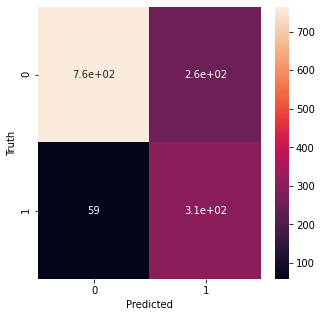

In [63]:
cm4 = confusion_matrix(y_test1, y_pred4)
print(len(y_test1))
import seaborn as sn
import matplotlib.pyplot as plt
plt.figure(figsize = (5,5))
sn.heatmap(cm4, annot = True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

Saving the predictions in the dataframe.

In [64]:
predictions['ANN_predictions'] = pd.Series(y_pred4, index = y_test1.index).replace({0: "No", 1: "Yes"})
print(predictions.shape)
predictions.head()

(1384, 23)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Random_forest_predictions,KNN_predictions,ANN_predictions
customerID,,,,,,,,,,,,,,,,,,,,,,,
4760-XOHVN,Female,No,Yes,Yes,1,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,19.450001,19.450001,Yes,Yes,No,No
0363-QJVFX,Male,No,No,No,32,Yes,Yes,Fiber optic,Yes,Yes,No,Yes,Yes,Yes,Month-to-month,Yes,Credit card (automatic),108.150002,3432.899902,Yes,No,No,No
8329-GWVPJ,Female,No,Yes,Yes,50,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),69.750000,3557.699951,No,Yes,Yes,Yes
4547-LYTDD,Female,No,No,No,16,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,No,Electronic check,72.650002,1194.300049,Yes,Yes,Yes,Yes
3665-JATSN,Female,No,No,No,19,No,No phone service,DSL,No,Yes,No,No,No,Yes,Month-to-month,Yes,Electronic check,39.700001,710.049988,No,No,No,Yes


We can also check how many params where created and involved in the calculation to run this model.

In [65]:
ann.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                192       
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 225
Trainable params: 225
Non-trainable params: 0
_________________________________________________________________


# Evaluating the models

The most observed metrics were balanced accuracy (considering the classes are unbalaced), precision and recall. There are other possible metrics to be analysed but this metrics are the most relevant for our problem.

The balanced accuracy measures how many of the predictions were right in each class, and calculates the weighted average considering the representation in both classes (classes less represented will have highest weight). the balanced accuracy is a good metric when you need both precision and recall, in other words, when you need a good prediction rate in both classes.

Consider TP = True positive (class 1, labeled as 1), FP = False positive (class 0, labeled as 1), FN = False Negative (class 1, labeled as 0).

The precision measures what fraction of the class prediction was actually right. Using precision as a metric is a good option when false positives are more damaging to the task than false negatives, because the occurence of false positives will decrease precision.

$Precision = {TP / (TP + FP)}$

The recall measures what fraction of the true class was actually labeled as that class. Using recall as a metric is a good option when false negatives are more damaging to the task than false positives, because the occurence of false negatives will decrease recall.

$Recall = {TP / (TP + FN)}$

## Metric: Recall

In this task we want to predict possible churn of customers in order to prevent by inplementing retention models. In this case, is much more important to identify all possible churns correctly, even if we missclassify loyal customers as possible churn, than to consider a lot of customers that will most likely leave the base as being loyal and miss the opportunity to prevent churn. 

Therefore the best metric to consider here would be RECALL, specially inside the churn class, because having False Negatives (customers that will churn being classified as not likely to churn) is much more damaging to the company. 

Of course that the balanced accuracy is also important, because the company doesn't want to spend time and resources to prevent churn from customers that are loyal, but at least the difference in balanced accuracy is big, looking at recall is better.

In [66]:
print(f'Metrics for Random forest: \n {randforest_classif} \n balanced accuracy: {balanced_accuracy_score(y_test1, y_pred1)}')
print('----------------------------------')
print(f'Metrics for K-nearest neighbors: \n {knn_classif} \n balanced accuracy: {balanced_accuracy_score(y_test1, y_pred3)}')
print('----------------------------------')
print(f'Metrics for Artificial neural network: \n {ann_classif} \n balanced accuracy: {balanced_accuracy_score(y_test1, y_pred4)}')

Metrics for Random forest: 
               precision    recall  f1-score   support

           0       0.92      0.76      0.83      1019
           1       0.54      0.81      0.65       365

    accuracy                           0.77      1384
   macro avg       0.73      0.78      0.74      1384
weighted avg       0.82      0.77      0.78      1384
 
 balanced accuracy: 0.7824216596986033
----------------------------------
Metrics for K-nearest neighbors: 
               precision    recall  f1-score   support

           0       0.84      0.89      0.86      1019
           1       0.64      0.51      0.57       365

    accuracy                           0.79      1384
   macro avg       0.74      0.70      0.72      1384
weighted avg       0.78      0.79      0.79      1384
 
 balanced accuracy: 0.7036619301759717
----------------------------------
Metrics for Artificial neural network: 
               precision    recall  f1-score   support

           0       0.93      0.75   

## Model: ANN

The best model is the ANN because it had the highest recall, specially the recall inside the class 1 (customers likely to leave the base), and also had the highest balanced accuracy, which is a bonus. It is important to consider that the training of this model took much longer than the other models to train, around 800x more than the second best model, so if training time is relevant for the company, it could be interesting to use Random forest, that is much faster and has similar results.

At last but not least, saving this predictions in a csv:

In [68]:
predictions.to_csv('Churn_PREDICTIONS.csv')